In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
import pandas as pd


def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


#  Understand land surface data
##  1.  Load the landsurface data

In [ ]:
fsurdat: str = "/home/jguo/projects/cesm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc"
# Load the dataset
ds_sur = xr.open_mfdataset(fsurdat)
ds_sur

##  2. Assign coordinate value to be actual lat and lon degree not the index

In [ ]:
print(ds_sur.coords)
print(ds_sur.dims)

In [ ]:
# Extract a column of unique latitudes and a row of unique longitudes as raw arrays
# convert to float32 to match the hw temperature data later. this gave me a lot of trouble
unique_lats = ds_sur['LATIXY'].isel(lsmlon=0).data.astype('float32')  # Extracting the raw array for latitudes
unique_lons = ds_sur['LONGXY'].isel(lsmlat=0).data.astype('float32')  # Extracting the raw array for longitudes

# Assign these raw arrays as new coordinates (without specifying old dimensions)
ds_sur = ds_sur.assign_coords(lat=('lsmlat', unique_lats), lon=('lsmlon', unique_lons))

# Swap 'lsmlat' and 'lsmlon' dimensions with 'lat' and 'lon'
ds_sur = ds_sur.swap_dims({'lsmlat': 'lat', 'lsmlon': 'lon'})

# Drop the original 'lsmlat' and 'lsmlon' dimensions if they are no longer needed
ds_sur = ds_sur.drop_vars(['lsmlat', 'lsmlon'], errors='ignore')


# Now, your DataArray or any variable extracted from ds_sur should have 1 dimensionional (1D) lat and lon coordinates
total_urban_pct = ds_sur['PCT_URBAN']  # Example variable
print(total_urban_pct)

# At this point, the dataset dimensions will be based on actual latitude and longitude values



##  3.  Determine which grid is Urban

In [ ]:
# Access the PCT_URBAN variable
pct_urban = ds_sur['PCT_URBAN']
pct_urban


In [ ]:
# Sum across the 'numurbl' dimension to get total urban coverage

# https://bb.cgd.ucar.edu/cesm/threads/proportion-of-cities-in-surface-data.8046/
# PCT_URBAN is the percent of each urban density type. The density types in order are
# tall building district (TBD), high density (HD), and medium density (MD).
# If you change those percentages, e.g, increase them, then you'll need to decrease
# some other surface type (e.g., PCT_NATVEG, PCT_CROP, PCT_LAKE, etc.).
# The sum of PCT_URBAN, PCT_NATVEG, PCT_CROP, PCT_LAKE, PCT_GLACIER, PCT_WETLAND needs to be 100%.
# PCT_URBAN has multiple layers for different urban density types, sum across the 'numurbl' dimension to get total urban coverage
total_urban_pct = pct_urban.sum(dim='numurbl')
print(total_urban_pct)
total_urban_pct


##  4.  Create a mask for the urban grid, the mask is variable masked_urban_areas

In [ ]:
# Use .where() to assign 1 to urban cells (where total urban percentage > 2%) and NaN to others
urban_grid_mask = total_urban_pct.where(total_urban_pct > 0.1, other=np.nan)

# Now, replace all non-NaN values (which indicate urban areas) with 1
# This is done by utilizing the np.where function from the numpy library to replace non-NaN (i.e., urban) values with 1
urban_grid_binary = xr.where(urban_grid_mask.notnull(), 1, urban_grid_mask)



def find_top_urban_areas(masked_urban_areas):
    # Convert the stacked DataArray to a pandas DataFrame
    df = masked_urban_areas.stack(z=('lat', 'lon')).to_dataframe(name='urban_pct')

    # Use the nlargest method on the DataFrame to find the top 50 values
    top_urban_areas_df = df.nlargest(50, 'urban_pct')
    # Drop the redundant 'lsmlat' and 'lsmlon' columns
    top_urban_areas_df = top_urban_areas_df.drop(columns=['lat', 'lon'])

    return top_urban_areas_df


# Call the function with the masked_urban_areas variable
top_urban_areas = find_top_urban_areas(urban_grid_mask)
print(top_urban_areas)

print( "percentage grid cells are urban:", urban_grid_mask.count().compute().item() * 100 / (192 * 288), "%")

# Rename dimensions in urban_grid_binary to match those in HW
# urban_grid_binary = urban_grid_binary.rename({'lsmlat': 'lat', 'lsmlon': 'lon'})
urban_grid_binary



##  5.  Plot the urban grid

In [ ]:
urban_grid_mask.plot()

In [ ]:
# Plotting
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Get longitude and latitude information from the dataset
longitude = ds_sur['LONGXY']
latitude = ds_sur['LATIXY']

# Plotting the urban areas that meet the condition
# Note: urban_grid_mask already has values below 2% filtered out, so we use it directly
plt.pcolormesh(longitude, latitude, urban_grid_mask, transform=ccrs.PlateCarree(), cmap='cool') #cmap='cool') cmap='Reds')

plt.colorbar(label='Total Urban Percentage')
plt.title('Urban Areas with More Than 2% Urban Coverage')
plt.show()

##  6.  Use TSA_U to determine urban grid

In [2]:
one_monthly_file = '/tmpdata/summerized_data/i.e215.I2000Clm50SpGs.hw_production.02/sub_sample/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-01.nc'
ds_monthly = xr.open_dataset(one_monthly_file)
ds_monthly.TSA_U

<xarray.DataArray 'TSA_U' (time: 1, lat: 192, lon: 288)>
[55296 values with dtype=float32]
Coordinates:
  * time     (time) object 1985-02-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    long_name:     Urban 2m air temperature
    units:         K
    cell_methods:  time: mean

In [50]:
#put all variables in ds_monthly in a list
ds_monthly_vars = list(ds_monthly.data_vars)
ds_monthly_vars


['mcdate',
 'mcsec',
 'mdcur',
 'mscur',
 'nstep',
 'time_bounds',
 'date_written',
 'time_written',
 'area',
 'landfrac',
 'landmask',
 'pftmask',
 'nbedrock',
 'ZSOI',
 'DZSOI',
 'WATSAT',
 'SUCSAT',
 'BSW',
 'HKSAT',
 'ZLAKE',
 'DZLAKE',
 'APPAR_TEMP',
 'APPAR_TEMP_R',
 'APPAR_TEMP_U',
 'EFLX_LH_TOT',
 'EFLX_LH_TOT_R',
 'EFLX_LH_TOT_U',
 'FGR',
 'FGR_R',
 'FGR_U',
 'FIRA',
 'FIRA_R',
 'FIRA_U',
 'FIRE',
 'FIRE_R',
 'FIRE_U',
 'FLDS',
 'FSA',
 'FSA_R',
 'FSA_U',
 'FSDS',
 'FSH',
 'FSH_R',
 'FSH_U',
 'HEAT_FROM_AC',
 'HIA',
 'HIA_R',
 'HIA_U',
 'PBOT',
 'Q2M',
 'Q2M_R',
 'Q2M_U',
 'QBOT',
 'RAIN',
 'RH2M',
 'RH2M_R',
 'RH2M_U',
 'SNOW',
 'TBOT',
 'THBOT',
 'TSA',
 'TSA_R',
 'TSA_U',
 'TSKIN',
 'TSKIN_R',
 'TSKIN_U',
 'U10',
 'URBAN_HEAT',
 'VAPOR_PRES',
 'VAPOR_PRES_R',
 'VAPOR_PRES_U',
 'WASTEHEAT',
 'WBA',
 'WBA_R',
 'WBA_U',
 'WIND']

In [ ]:

ds_monthly.TSA_U.plot()

In [4]:
#urban_grid_binary_from_TSA_U = xr.where(ds_monthly.TSA_U > 0 , 1, urban_grid_mask)
#print in 2digits prcecision percentage of urban grid cells
print(f"urban: {ds_monthly.TSA_U.notnull().sum().compute().item() *100/(288*192):.1f}%")


urban: 7.7%


In [3]:
# Select the 'TSA_U' variable and get the non-null mask
# Using the .isel() method to select the first time slice
urban_non_null_mask = ds_monthly['TSA_U'].isel(time=0).notnull().drop('time')   
urban_non_null_mask

# # Apply the mask to filter the dataset
# ds_filtered = ds_monthly.where(urban_non_null_mask, drop=True)
# 
# # Now 'ds_filtered' contains only the grid cells where 'TSA_U' is not null
# ds_filtered

<xarray.DataArray 'TSA_U' (lat: 192, lon: 288)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


#  Define HW Temporal filter
##  1.  Load the daily(h1 tape) simulation temperature data

Load the dataset, I copied the daily h1 files to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/daily_raw it is 137G in total
I run the utils/extract_var_save.py to extract the subset of variables from the above directory
and save the data to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary

In [4]:
hw_summary_dir = '/home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary'
hw_output_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.hwdays.nc'
hw_out_file_path = os.path.join(hw_summary_dir, hw_output_file)
#check if hw_file exists
hw_file_exist = os.path.isfile(hw_out_file_path)


##  2   For each grid cell the find time periods that satisfy the HW definition. 

We use the definition from the US National Weather Service (NWS): three or more consecutive days of maximumtemperature reaching at least 90 ◦F (32.2 ◦C). 
We consider that, in each grid cell (a size on the order of 100 × 100 km), its rural sub-grid represents a local background environment for the city. 
Therefore, for each city we use its rural 2m-height temperature (T2m,rural) to define HWs.

We use this variable in the daily h1 file: TREFMXAV_R:long_name = "Rural daily maximum of average 2-m temperature" ;

In [30]:
fahrenheit_threshold = 90
kelvin_threshold = (fahrenheit_threshold - 32) * (5/9) + 273.15

In [5]:

#if hw_file does not exist, then we need to run the following code to create the hw_file
if not hw_file_exist:
    # Open the NetCDF file containing the rural daily maximum of average 2-m temperature
    hw_input_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.TSA_UR_TREFMXAV_R.nc'
    hw_input_file_path = os.path.join(hw_summary_dir, hw_input_file)
    ds_hw = xr.open_dataset(hw_input_file_path)
    ds_hw
    # Define the threshold temperature in Kelvin
    # Convert 90 degrees Fahrenheit to Kelvin
    fahrenheit_threshold = 90
    kelvin_threshold = (fahrenheit_threshold - 32) * (5/9) + 273.15

    # Define a function to apply on each grid cell to detect heatwaves
    def detect_heatwave(tsa_r_np):
        # Ensure tsa_r_np is a 1D array for simplicity
        tsa_r_np = np.atleast_1d(tsa_r_np)
        hw = np.full(tsa_r_np.shape, np.nan)  # Initialize HW with NaN

        # Check for heatwaves
        for i in range(2, len(tsa_r_np)):
            if (tsa_r_np[i-2] > kelvin_threshold and
                    tsa_r_np[i-1] > kelvin_threshold and
                    tsa_r_np[i] > kelvin_threshold):
                hw[i-2:i+1] = 1  # Mark all three days as heatwave

        return hw

    # Use apply_ufunc to apply the detect_heatwave function across the dataset
    hw = xr.apply_ufunc(
        detect_heatwave, ds_hw['TREFMXAV_R'],
        input_core_dims=[['time']],  # Specify the core dimension
        output_core_dims=[['time']],  # Ensure output has the same core dimension as input
        vectorize=True,  # Enable broadcasting and looping over other dimensions
        output_dtypes=[float]  # Specify the output data type
    )
    # Optional: save the modified dataset to a new NetCDF file
    # Assign the HW data back to the original dataset as a new variable
    ds_hw['HW'] = hw
    ds_hw.to_netcdf(hw_out_file_path)   
else:
    # Load the existing HW data
    ds_hw =xr.open_dataset(hw_out_file_path)
    hw = ds_hw['HW']    

print(hw)
hw


<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

In [ ]:
ds_hw


##  3.  The outcome should be 2D array with 1 for HW day and 0 for non HW day, the xarray should daily time dimension.

In [ ]:
#todo read hw from the output file hw_file_path
hw


##  4.  Interecting the HW grid with the Urban grid, we can find the HW days for each urban grid

In [6]:


print(hw.lon.equals(urban_non_null_mask.lon))
print(hw.lat.equals(urban_non_null_mask.lat))

print(type(urban_non_null_mask.lon))
print(type(hw.lon))
print('\nurban_non_null_mask.lon:\n', urban_non_null_mask.lon, '\n')
print("hw.lon:\n", hw.lon, '\n')

True
True
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>

urban_non_null_mask.lon:
 <xarray.DataArray 'lon' (lon: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  coordinate longitude
    units:      degrees_east 

hw.lon:
 <xarray.DataArray 'lon' (lon: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  coordinate longitude
    units:      degrees_east 


In [44]:
ds_hw

<xarray.Dataset>
Dimensions:     (time: 10951, lat: 192, lon: 288)
Coordinates:
  * time        (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon         (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat         (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TSA         (time, lat, lon) float32 ...
    TSA_U       (time, lat, lon) float32 ...
    TSA_R       (time, lat, lon) float32 ...
    TREFMXAV_R  (time, lat, lon) float32 ...
    HW          (lat, lon, time) float64 ...
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:07:44
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1

In [8]:
urban_non_null_mask

<xarray.DataArray 'TSA_U' (lat: 192, lon: 288)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

In [9]:
# Apply the mask to filter the dataset
# Apply the urban mask across all time points without dropping any
ds_hw_filtered = ds_hw.where(urban_non_null_mask.broadcast_like(ds_hw), drop=False)
ds_hw_filtered

<xarray.Dataset>
Dimensions:     (time: 10951, lat: 192, lon: 288)
Coordinates:
  * time        (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon         (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat         (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TSA         (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    TSA_U       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    TSA_R       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    TREFMXAV_R  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    HW          (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:07:44
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1

In [ ]:
# report 

In [0]:
hw = ds_hw_filtered['HW']

<xarray.Dataset>
Dimensions:     (lat: 60, lon: 105)
Coordinates:
  * lon         (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat         (lat) float32 -39.11 -36.28 -35.34 -33.46 ... 19.32 20.26 21.2
Data variables:
    TSA         (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    TSA_U       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    TSA_R       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    TREFMXAV_R  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    HW          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:07:44
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1

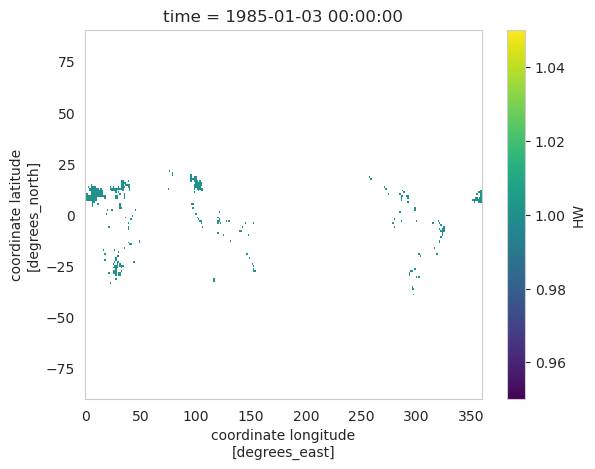

In [28]:
# Debug
# check in hw, how many grid cells has hw == 1 on the first day
hw_i = ds_hw_filtered.isel(time=2)
hw_i['HW'].plot()

# Select data where 'HW' equals 1
hw_condition_met = hw_i.where(hw_i['HW'] == 1, drop=True).drop('time')
hw_condition_met['HW'].sum()
hw_condition_met

In [43]:

# Convert the filtered dataset to a pandas DataFrame
df = ds_hw_filtered.isel(time=slice(1, 2)).to_dataframe()

# Reset the index if 'lat' and 'lon' are part of a MultiIndex
df_reset = df.reset_index()

# Filter the DataFrame for rows where 'HW' equals 1
df_hw_1 = df[df['HW'] == 1]

# Sort the filtered DataFrame by 'lat' and then by 'lon'
df_hw_1_sorted = df_hw_1.sort_values(by=['lat', 'lon'])

# Set the maximum number of columns to display
pd.set_option('display.max_columns', 50)  # Adjust the number as needed

# Print the sorted, filtered DataFrame
df_hw_1_sorted






TSA       TSA_U       TSA_R  \
time                lat        lon                                          
1985-01-02 00:00:00 -39.109947 297.50  295.397461  295.798859  295.392731   
                    -33.455498 22.50   298.715637  299.397919  298.714539   
                    -31.570681 27.50   296.750183  297.122192  296.749817   
                               116.25  297.725616  297.987701  297.720642   
                    -30.628273 300.00  299.880402  301.264374  299.861298   
...                                           ...         ...         ...   
                     18.376963 257.50  297.970032  298.592560  297.971619   
                     19.319372 78.75   298.520966  298.553925  298.519836   
                               95.00   298.484009  298.236542  298.484253   
                               96.25   299.072998  299.192871  299.072052   
                     21.204189 76.25   298.262482  298.849854  298.235809   

                                       TREFMXAV_R   HW  
time                lat        lon                      
1985-01-02 00:00:00 -39.109947 297.50  305.440796  1.0  
                    -33.455498 22.50   305.872711  1.0  
                    -31.570681 27.50   306.735260  1.0  
                               116.25  305.797943  1.0  
                    -30.628273 300.00  307.874512  1.0  
...                                           ...  ...  
                     18.376963 257.50  305.659912  1.0  
                     19.319372 78.75   305.385773  1.0  
                               95.00   306.785522  1.0  
                               96.25   307.666046  1.0  
                     21.204189 76.25   306.830719  1.0  

[328 rows x 5 columns]

In [11]:

# Sum over the spatial dimensions to count the number of HW == 1 cells for each day
# Assuming 'lat' and 'lon' are the names of your spatial dimensions
daily_hw_urban_count = hw.sum(dim=['lat', 'lon']).compute()


In [12]:

# daily_hw_urban_count_computed now contains the daily count of urban grid cells with HW == 1
print(daily_hw_urban_count)

#print out daily count of urban grid cells for days that has count > 1
hw_dates= daily_hw_urban_count.where(daily_hw_urban_count > 1, drop=True)


<xarray.DataArray 'HW' (time: 10951)>
array([  0., 328., 360., ..., 467., 404., 346.])
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00


In [46]:
#convert hw_dates to df
df_hw_dates = hw_dates.to_dataframe()
df_hw_dates

,HW
time,
1985-01-02 00:00:00,328.0
1985-01-03 00:00:00,360.0
1985-01-04 00:00:00,411.0
1985-01-05 00:00:00,435.0
1985-01-06 00:00:00,447.0
...,...
2014-12-28 00:00:00,462.0
2014-12-29 00:00:00,452.0
2014-12-30 00:00:00,467.0


In [13]:
#save hw_dates to a file
hw_dates.to_netcdf('/home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary/hw_dates.nc')   

In [ ]:
# Step 1: Mask the hw dataset to only include grid cells marked as urban in urban_grid_binary
hw_urban = hw.where(urban_grid_binary == 1)

# Step 2: Reduce the hw_urban dataset along spatial dimensions to identify any heatwave occurrence in urban areas for each date
# The reduction will result in a DataArray where each time point has a value of True if any urban grid cell experienced a heatwave, and False otherwise
hw_urban_any = hw_urban.reduce(np.any, dim=['lat', 'lon'])
# Ensure hw_urban_any is computed if it's a Dask array and convert time to a pandas Timestamp
hw_urban_any_computed = hw_urban_any.compute()

In [ ]:

# Step 3: Filter the time coordinate where there's at least one urban heatwave, which gives us the dates we're interested in
hw_dates = hw_urban_any_computed.time.where(hw_urban_any_computed, drop=True)

# Convert the hw_dates xarray DataArray to a list of pandas Timestamps for easier interpretation and use
hw_dates_list = pd.to_datetime(hw_dates.values).tolist()

# Print the resulting list of dates
print(hw_dates_list)




In [ ]:
print(hw_urban)
hw_urban.isel(time=0).drop(['time'])


###  4.1 make sure we do north and south hemisphere correctly
##  5. Compute the "HW days for Any grid" list of dates. I need to load file on that day if any grid has a HW day.  

In [ ]:
# Check when HW == 1 for any grid cell and reduce the data array to a 1D time series
heatwave_days = hw_urban.any(dim=('lat', 'lon')).compute() #reduce the data array to a 1D time series

# Extract the dates where the condition is True
heatwave_dates = hw_urban['time'].where(heatwave_days, drop=True)

# Print the dates
print(heatwave_dates.values)

In [ ]:
# Count the number of HW days
num_hw_days = heatwave_dates.size

print("Number of Heatwave Days:", num_hw_days)


###  5.1  further descrease that list by 


#  Process hourly simulation output data
##  1. On a given hourly time slice, compute the UHI for all grid cells that are urban and HW (marked as HW == 1) (grid level hourly)
###  1.1 TSA_U > 0 is urban cell
###  1.2 HW is defined with above code. Grid level daily. 
##  2. For each year on summer time-series, Compute summer average UHI for each given hour of the day for a given urban cell (Grid level summer monthly)
###  2.1 Compute summer average UHI for given hour of day for a given urban cell using monthly data
##  3. For each year on summer time-series, Compute UHI for a given urban and HW cell. (grid level hourly)
###  3.1 Compute UHI for a given urban and HW cell
##  4. Compute "UHI interaction", UHI with HW - UHI (Grid level hourly)
###   4.1 Compute summer average UHI for each grid cell
###   4.2 Compute UHI interaction for each grid cell: HW grid level UHI - grid level Summer average UHI for each given hour of day

#  Explain the "UHI interaction" (defined above) 
## 1.  ML model left hand side (LHS) UHI interaction. Right hand side (RHS) factors. 
###  1.1 LHS is hourly single cell data for "UHI interaction"
###  1.2 RHS contains lon, lat, hourly time, humidity, distance to shore, different part of day, surface roughness, albedo (R and U), precipitation, vegetation (TODO: study different types of vegetation, pct, etc.) 
###  1.3 We want to figure out contribution for each RHS factor to the LHS UHI interaction. Plan to use SHAP.












##  1. Load the hourly simulation temperature data from "HW days for Any grid" list of dates
##  2. Convert UTC to local time 
##  3. Compute the UHI for 2m air T for each HW grid
##  4. Compute the UWBI for surface for each HW grid





















##  1.  feature engineering, the right hand side factors
###  1.1  humidity(precipitation))
###  1.2  distance to shore (what about big lakes)?
###  1.3  Different part of day (morning, afternoon, evening, night)
###  1.4  Surface roughness, albedo, vegetation



SHAP values explain the prediction of an instance by computing the contribution of each feature to the prediction. The SHAP value of a feature for a particular prediction indicates the impact of that feature being introduced into a conditional expectation model of the prediction. 
